# Hybrid QNN for the classification of handwritten digit images of 4 vs 9

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.autograd import Function
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import qiskit
from qiskit import transpile, assemble
from qiskit.visualization import *

### Defining the quantum circuit:
- The circuit will do the following:
    - Set the qubits to superposition
    - Have a layer of Ry gates
    - Have a layer of CNOTs

In [3]:
class QuantumCircuit:
    """ 
    This class provides a simple interface for interaction 
    with the quantum circuit 
    """
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self._circuit = qiskit.QuantumCircuit(n_qubits)
        
        all_qubits = [i for i in range(n_qubits)]
        self.theta = qiskit.circuit.Parameter('theta')
        
        self._circuit.h(all_qubits)
        self._circuit.barrier()
        self._circuit.ry(self.theta, all_qubits)
        for j in range(n_qubits-1):
            self._circuit.cx(all_qubits[j],all_qubits[j+1])
            
        
        
        self._circuit.measure_all()
        # ---------------------------

        self.backend = backend
        self.shots = shots
    
    def run(self, thetas):
        t_qc = transpile(self._circuit,
                         self.backend)
        qobj = assemble(t_qc,
                        shots=self.shots,
                        parameter_binds = [{self.theta: theta} for theta in thetas])
        job = self.backend.run(qobj)
        result = job.result().get_counts()
        
        counts = np.array(list(result.values()))
        states = np.array(list(result.keys())).astype(float)
        
        # Compute probabilities for each state
        probabilities = counts / self.shots
        # Get state expectation
        expectation = np.sum(states * probabilities)
        
        return np.array([expectation])

### Visualizing the quantum circuit:

In [4]:
simulator = qiskit.Aer.get_backend('aer_simulator')

circuit = QuantumCircuit(4, simulator, 100)
print('Expected value for rotation pi {}'.format(circuit.run([np.pi])[0]))
circuit._circuit.draw()

Expected value for rotation pi 576.3299999999999


C:\Users\rohan\anaconda3\lib\site-packages\qiskit\circuit\tools\pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols
C:\Users\rohan\anaconda3\lib\site-packages\qiskit\circuit\tools\pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols
C:\Users\rohan\anaconda3\lib\site-packages\qiskit\circui

┌───┐ ░ ┌───────────┐                ░ ┌─┐         
   q_0: ┤ H ├─░─┤ RY(theta) ├──■─────────────░─┤M├─────────
        ├───┤ ░ ├───────────┤┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ┤ H ├─░─┤ RY(theta) ├┤ X ├──■────────░──╫─┤M├──────
        ├───┤ ░ ├───────────┤└───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ┤ H ├─░─┤ RY(theta) ├─────┤ X ├──■───░──╫──╫─┤M├───
        ├───┤ ░ ├───────────┤     └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ┤ H ├─░─┤ RY(theta) ├──────────┤ X ├─░──╫──╫──╫─┤M├
        └───┘ ░ └───────────┘          └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════════════════════╩══╩══╩══╩═
                                                0  1  2  3

In [5]:
class HybridFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, quantum_circuit, shift):
        """ Forward pass computation """
        ctx.shift = shift
        ctx.quantum_circuit = quantum_circuit

        expectation_z = ctx.quantum_circuit.run(input[0].tolist())
        result = torch.tensor([expectation_z])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
        """ Backward pass computation """
        input, expectation_z = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.shift
        shift_left = input_list - np.ones(input_list.shape) * ctx.shift
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class Hybrid(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, shift):
        super(Hybrid, self).__init__()
        self.quantum_circuit = QuantumCircuit(1, backend, shots)
        self.shift = shift
        
    def forward(self, input):
        return HybridFunction.apply(input, self.quantum_circuit, self.shift)

### Data loading and visualizing:

In [6]:
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 4 and 9 
idx = np.append(np.where(X_train.targets == 4)[0][:n_samples], 
                np.where(X_train.targets == 9)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Set 4's label to 0 and 9's label to 1 
X_train.targets[X_train.targets==4] = 0
X_train.targets[X_train.targets==9] = 1

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

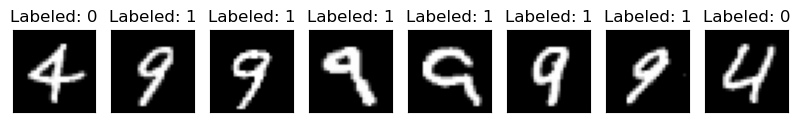

In [7]:
n_samples_show = 8

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [8]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 4)[0][:n_samples], 
                np.where(X_test.targets == 9)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Set 4's label to 0 and 9's label to 1
X_test.targets[X_test.targets==4] = 0
X_test.targets[X_test.targets==9] = 1

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

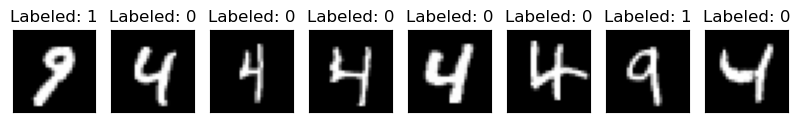

In [9]:
n_samples_show = 8

data_iter = iter(test_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

### The model:

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)
        self.hybrid = Hybrid(qiskit.Aer.get_backend('aer_simulator'), 100, np.pi / 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(1, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.hybrid(x)
        return torch.cat((x, 1 - x), -1)

### The training loop:

In [11]:
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

C:\Users\rohan\AppData\Local\Temp\ipykernel_26500\2571825612.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:248.)
  result = torch.tensor([expectation_z])
C:\Users\rohan\AppData\Local\Temp\ipykernel_26500\2571825612.py:32: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  gradients = np.array([gradients]).T


Training [5%]	Loss: -0.5321
Training [10%]	Loss: -0.8170
Training [15%]	Loss: -0.8705
Training [20%]	Loss: -0.9089
Training [25%]	Loss: -0.9257
Training [30%]	Loss: -0.9251
Training [35%]	Loss: -0.9385
Training [40%]	Loss: -0.9454
Training [45%]	Loss: -0.9444
Training [50%]	Loss: -0.9503
Training [55%]	Loss: -0.9455
Training [60%]	Loss: -0.9573
Training [65%]	Loss: -0.9627
Training [70%]	Loss: -0.9689
Training [75%]	Loss: -0.9651
Training [80%]	Loss: -0.9724
Training [85%]	Loss: -0.9732
Training [90%]	Loss: -0.9784
Training [95%]	Loss: -0.9744
Training [100%]	Loss: -0.9786


### Learning curve:

Text(0, 0.5, 'Neg Log Likelihood Loss')

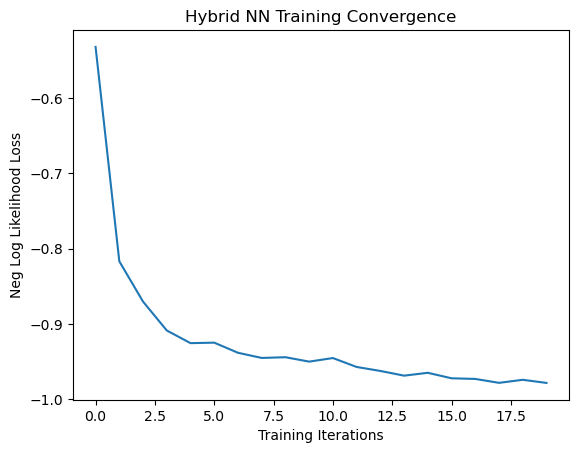

In [12]:
plt.plot(loss_list)
plt.title('Hybrid NN Training Convergence')
plt.xlabel('Training Iterations')
plt.ylabel('Neg Log Likelihood Loss')

### Evaluating the model's performance on the test dataset:

In [13]:
model.eval()
with torch.no_grad():
    
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        loss = loss_func(output, target)
        total_loss.append(loss.item())
        
    print('Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%'.format(
        sum(total_loss) / len(total_loss),
        correct / len(test_loader) * 100)
        )

Performance on test data:
	Loss: -0.9708
	Accuracy: 99.0%


### Some test examples:

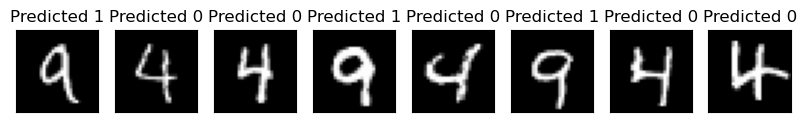

In [14]:
n_samples_show = 8
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model.eval()
with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model(data)
        
        pred = output.argmax(dim=1, keepdim=True) 

        axes[count].imshow(data[0].numpy().squeeze(), cmap='gray')

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title('Predicted {}'.format(pred.item()))
        
        count += 1

# Versions:

In [15]:
import qiskit.tools.jupyter
%qiskit_version_table

In [16]:
torch.__version__

'2.0.1+cpu'

# References:
- https://medium.com/mit-6-s089-intro-to-quantum-computing/a-hybrid-quantum-neural-network-for-mnist-classification-edc8ad28e4ed